## 07. PyTorch Experiment Tracking

- https://www.learnpytorch.io/07_pytorch_experiment_tracking/

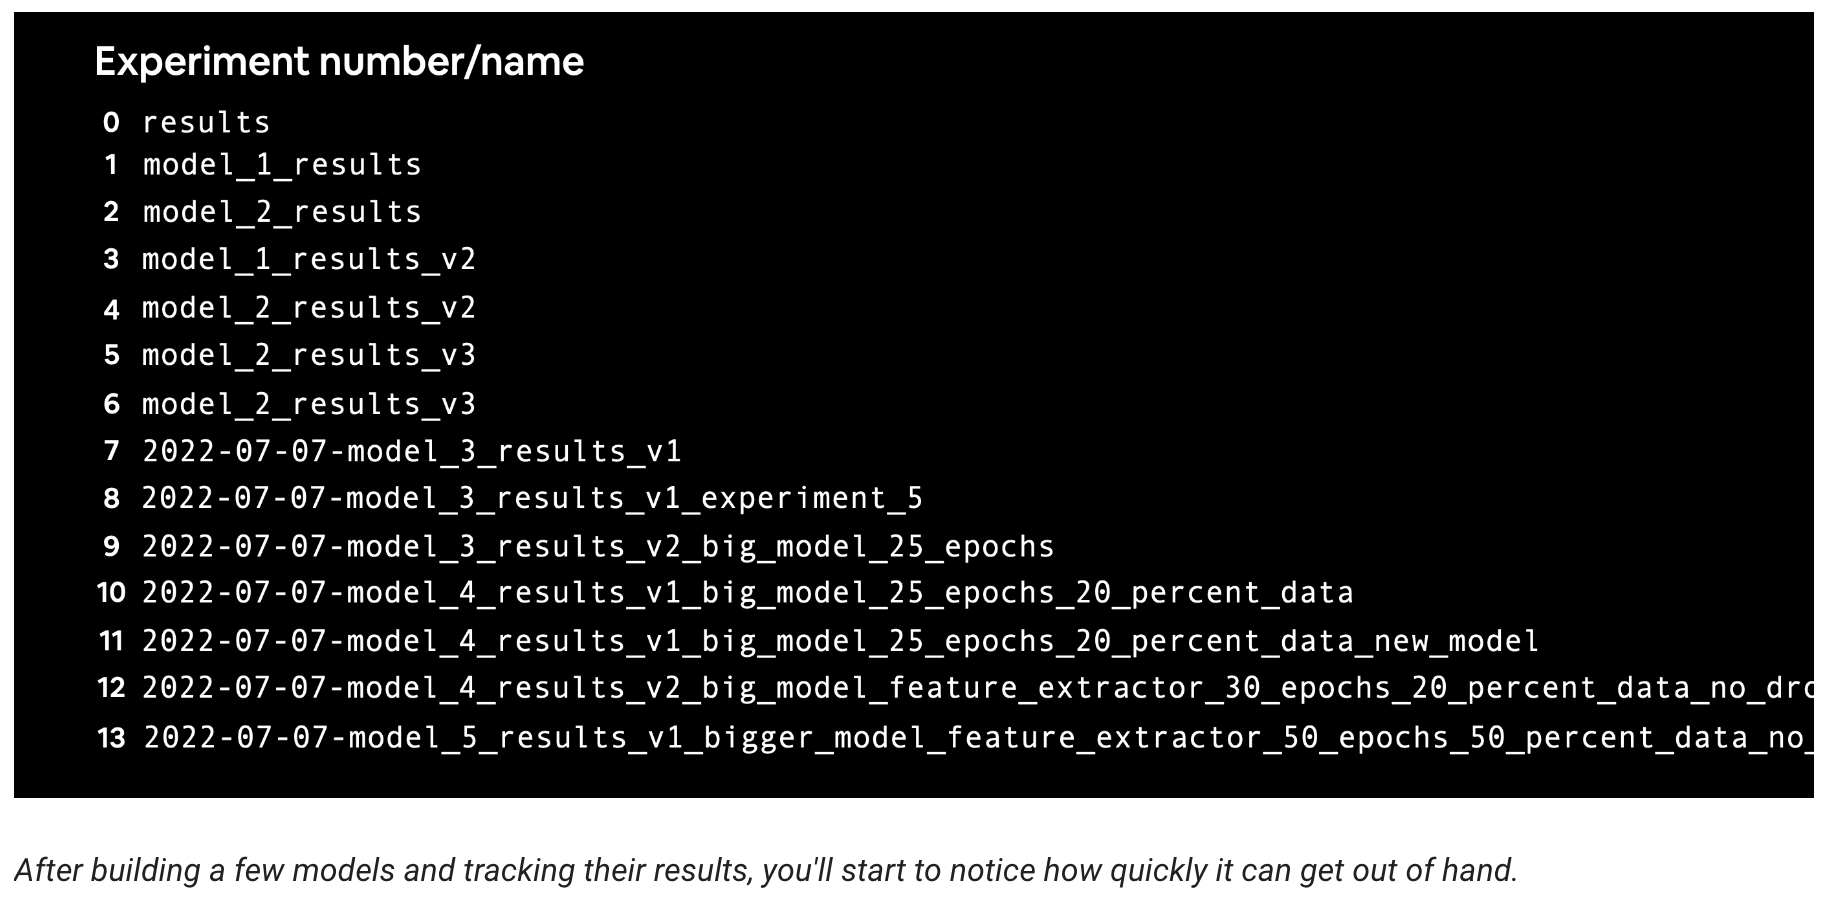

Different ways to track machine learning experiments

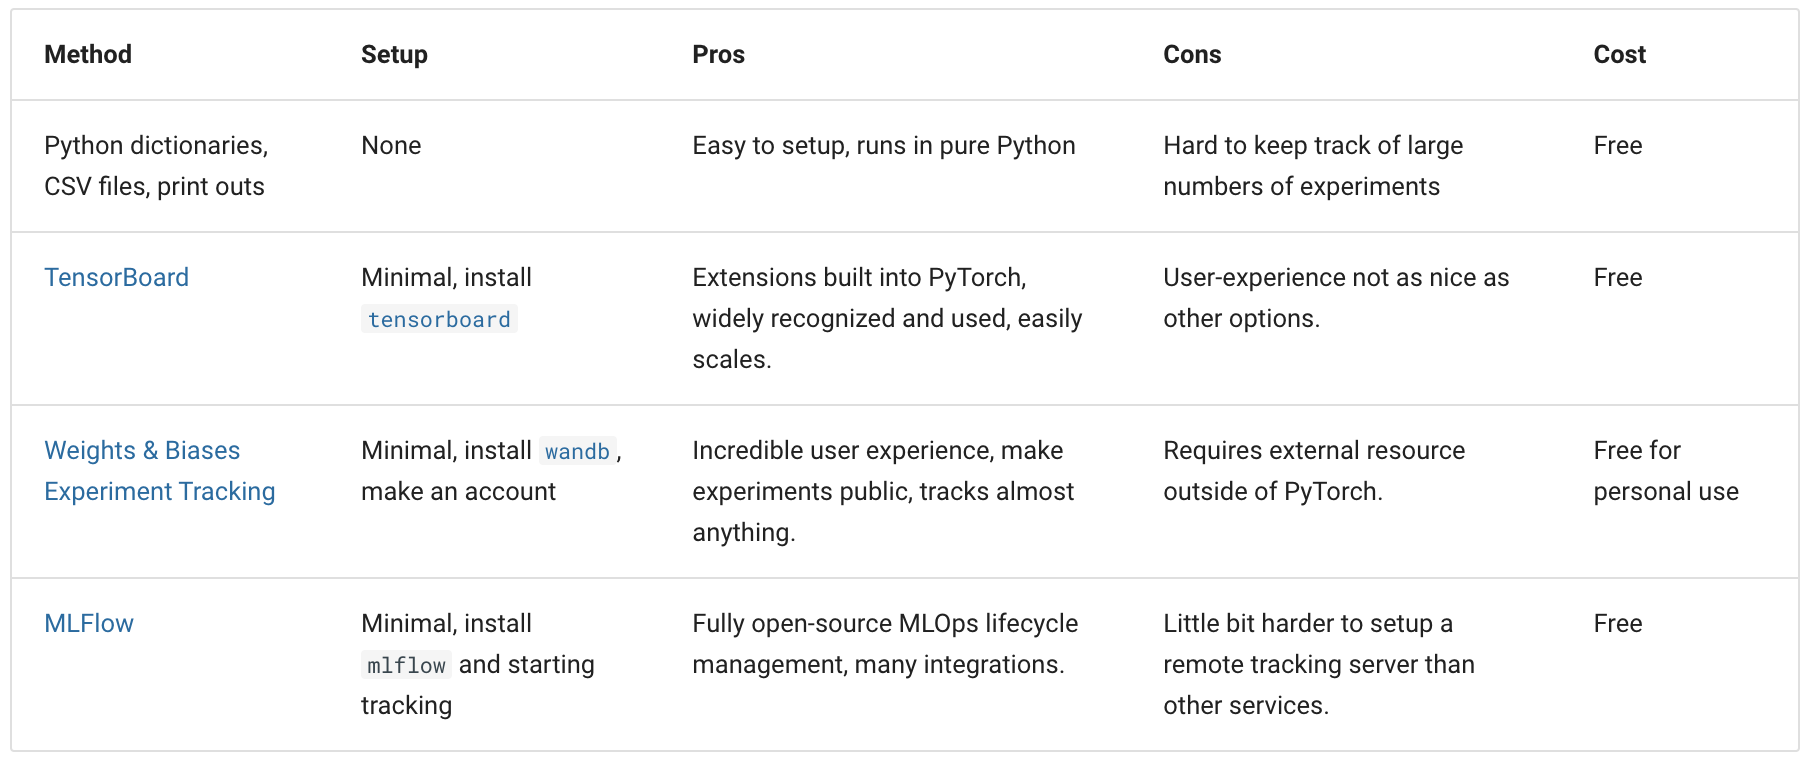

In [1]:
# try:
#     import torch
#     import torchvision
#     assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
#     assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
#     print(f"torch version: {torch.__version__}")
#     print(f"torchvision version: {torchvision.__version__}")
# except:
#     print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
#     !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
#     import torch
#     import torchvision
#     print(f"torch version: {torch.__version__}")
#     print(f"torchvision version: {torchvision.__version__}")

In [1]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

In [2]:
import sys

sys.path

['/Users/sguys99/Desktop/project/pytorch-study/zero-to-mastery',
 '/Users/sguys99/opt/anaconda3/envs/torch/lib/python39.zip',
 '/Users/sguys99/opt/anaconda3/envs/torch/lib/python3.9',
 '/Users/sguys99/opt/anaconda3/envs/torch/lib/python3.9/lib-dynload',
 '',
 '/Users/sguys99/opt/anaconda3/envs/torch/lib/python3.9/site-packages']

In [3]:
sys.path.append('/Users/sguys99/Desktop/project/pytorch-study/zero-to-mastery/05.Going_Modular/')

In [4]:
device = "cpu" if torch.cuda.is_available() else "cpu"
device

'cpu'

Create a helper function to set seeds

In [5]:
def set_seeds(seed: int = 42):
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

### 1. Get data

In [6]:
import os
import zipfile

from pathlib import Path

import requests

def download_data(source: str, 
                  destination: str,
                  remove_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination.

    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.
    
    Returns:
        pathlib.Path to downloaded data.
    
    Example usage:
        download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                      destination="pizza_steak_sushi")
    """
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it... 
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)
        
        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...") 
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)
    
    return image_path

image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [7]:
from going_modular import data_setup, engine

### 2. Create Datasets and DataLoaders

transform에는 2가지가 있다.  
- 매뉴얼 방법 : torchvision.transforms
- 자동방법 : `torchvision.models.MODEL_NAME.MODEL_WEIGHTS.DEFAULT.transforms()`

Create DataLoaders using manually created transforms

In [8]:
# Setup directories
train_dir = image_path / "train"
test_dir = image_path / "test"

# Setup ImageNet normalization levels (turns all images into similar distribution as ImageNet)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])           
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


In [9]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir = test_dir,
    transform=manual_transforms,
    batch_size=32
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x105e8b190>,
 ['pizza', 'steak', 'sushi'])

Create DataLoaders using automatically created transforms

In [10]:
# Setup dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

# Setup pretrained weights (plenty of these available in torchvision.models)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# Get transforms from weights (these are the transforms that were used to obtain the weights)
automatic_transforms = weights.transforms() 
print(f"Automatically created transforms: {automatic_transforms}")

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=automatic_transforms, # use automatic created transforms
    batch_size=32
)

train_dataloader, test_dataloader, class_names

Automatically created transforms: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


(<torch.utils.data.dataloader.DataLoader at 0x167a909a0>,
 ['pizza', 'steak', 'sushi'])

### 3. Getting a pretrained model, freezing the base layers and changing the classifier head

In [11]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [12]:
for param in model.features.parameters():
    param.requires_grad = False
    
# Since we're creating a new layer with random weights (torch.nn.Linear), 
# let's set the seeds
set_seeds() # 중요

model.classifier = torch.nn.Sequential(
    nn.Dropout(p = 0.2, inplace = True),
    nn.Linear(in_features=1280,
             out_features=len(class_names),
             bias=True).to(device))

In [13]:
from torchinfo import summary

# Get a summary of the model (uncomment for full output)
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

/Users/sguys99/opt/anaconda3/envs/torch/lib/python3.9/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

### 4. Train model and track results

In [14]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#### Adjust train() function to track results with SummaryWriter()

마지막으로 실험을 트래킹하기위해 한가지 더 추가하자.   

앞에서는 실험을 트래킹하기 위해서 딕셔너리를 사용했다.  
하지만 실험을 몇 개 이상 실행하면 문제가 커질 수 있다.  

torch.utils.tensorboard.SummaryWriter() 클래스를 사용하면 모델 학습 프로그래스의 다양한 부분을 파일로 저장할 수있다.  

디펄트로 SummaryWriter() 클래스는 다양한 정보를 log_dir 매개변수에 의해 설정된 파일에 저장한다.   

log_dir의 기본 위치는 runs/CURRENT_DATETIME_HOSTNAME 아래에 있으며, 여기서 HOSTNAME은 사용자 컴퓨터 이름이다.  

실험이 추적되는 위치는 변경할 수 있다(파일 이름은 원하는 대로 사용자 지정 가능).  

SummaryWriter()의 출력은 TensorBoard 형식으로 저장된다.  

TensorBoard는 TensorFlow 딥 러닝 라이브러리의 일부이다.

모델링 실험 추적을 시작하기 위해 기본 SummaryWriter() 인스턴스를 만들어 보겠습니다.  

In [15]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

In [16]:
writer

여기서는 앞에서의 engine.py에 있는 train() 함수를 writer를 사용할 수있도록 조정한다.   
다시말해 train() 함수에 모델의 학습, 시험 loss accuracy 등을 로깅할 수 있도록 한다.   


이를 위해서 writer.add_scalars(main_tag, tag_scalar_dict)를 사용하면 된다. 여기서  ...  
- main_tag (string) - 트래킹할 스칼라의 이름 (e.g. "Accuracy")
- tag_scalar_dict (dict) - 트래킹할 딕셔너리 (e.g. {"train_loss": 0.3454})

add_scalars()로 불리는 이유는 loss and accuracy values 가 스칼라이기 때문이다. (single values).

트래킹이 끝나면 writer.close()를 호츨하여 writer가 트래킹하기 위해 값들을 보지 않도록 한다.

In [17]:
from typing import Dict, List
from tqdm.auto import tqdm

from going_modular.engine import train_step, test_step

In [19]:
def train(model: torch.nn.Module,
         train_dataloader: torch.utils.data.DataLoader,
         test_dataloader: torch.utils.data.DataLoader,
         optimizer: torch.optim.Optimizer,
         loss_fn: torch.nn.Module,
         epochs: int,
         device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").
      
    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for 
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]} 
      For example if training for epochs=2: 
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]} 
    """
    
    # create empty results dictionary
    results = {"train_loss": [],
              "train_acc": [],
              "test_loss": [],
              "test_acc": []
              }
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn = loss_fn,
                                          optimizer=optimizer,
                                          device = device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)
        
        
        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
        ### New: Experiment tracking ###
        
        # add loss results
        writer.add_scalars(main_tag="Loss", 
                           tag_scalar_dict={"train_loss": train_loss,
                                            "test_loss": test_loss},
                           global_step=epoch)

        # Add accuracy results to SummaryWriter
        writer.add_scalars(main_tag="Accuracy", 
                           tag_scalar_dict={"train_acc": train_acc,
                                            "test_acc": test_acc}, 
                           global_step=epoch)
        
        # Track the pytorch model architecture
        writer.add_graph(model = model,
                        # 예제입력 집어넣기
                        input_to_model=torch.randn(32, 3, 224, 224).to(device))
        
    # close the writer
    writer.close()
    
    return results

5 에포크로 학습을 진행하자.

In [20]:
set_seeds()
results = train(model = model,
               train_dataloader=train_dataloader,
               test_dataloader=test_dataloader,
               optimizer=optimizer,
               loss_fn = loss_fn,
               epochs=5,
               device = device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0901 | train_acc: 0.4102 | test_loss: 0.8925 | test_acc: 0.6714
Epoch: 2 | train_loss: 0.8940 | train_acc: 0.6562 | test_loss: 0.8082 | test_acc: 0.7746
Epoch: 3 | train_loss: 0.7455 | train_acc: 0.8398 | test_loss: 0.7417 | test_acc: 0.7642
Epoch: 4 | train_loss: 0.7817 | train_acc: 0.6953 | test_loss: 0.6820 | test_acc: 0.8144
Epoch: 5 | train_loss: 0.6320 | train_acc: 0.7734 | test_loss: 0.6400 | test_acc: 0.8665


writer 인스턴스가 runs 디렉토리 아래에 결과를 기록한다.

```sh
runs/Jun21_00-46-03_daniels_macbook_pro
```

In [21]:
results

{'train_loss': [1.0900878012180328,
  0.8940204679965973,
  0.7455479577183723,
  0.7816760838031769,
  0.6320082023739815],
 'train_acc': [0.41015625, 0.65625, 0.83984375, 0.6953125, 0.7734375],
 'test_loss': [0.8924646576245626,
  0.80817844470342,
  0.741721530755361,
  0.6819637616475424,
  0.6400359272956848],
 'test_acc': [0.6714015151515151,
  0.774621212121212,
  0.7642045454545454,
  0.8143939393939394,
  0.8664772727272728]}

### 5. View our model's results in TensorBoard

SummaryWriter()는 모델 결과를 runs/ 디렉토리에 텐서보드 포맷으로 저장한다.

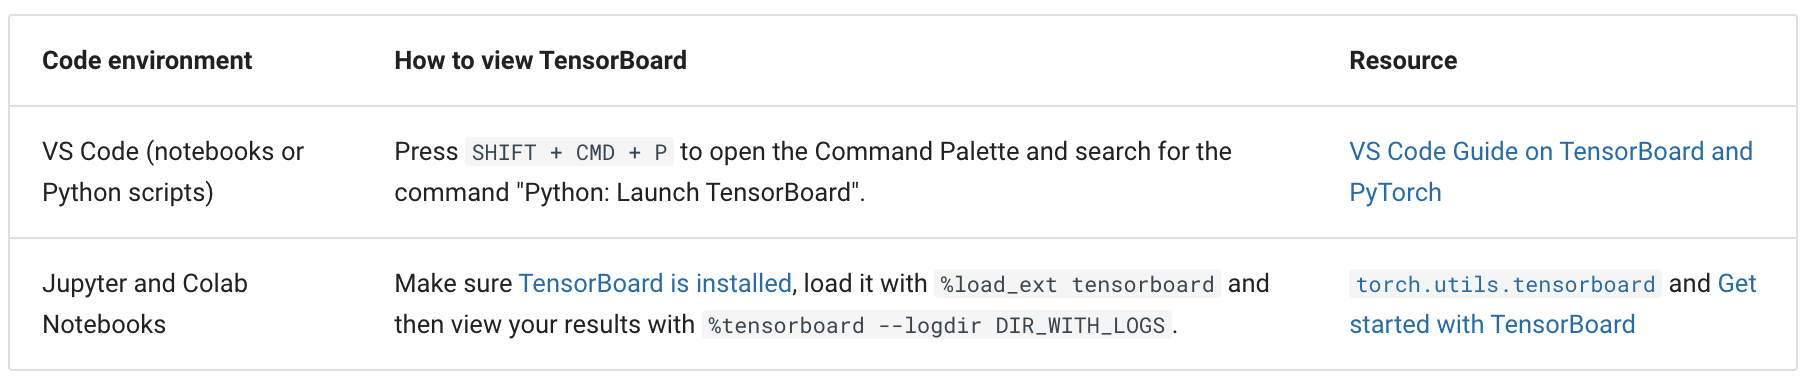

주피터 노트북에서 텐서보드를 실행하는 방법

```sh
%load_ext tensorboard # line magic to load TensorBoard
%tensorboard --logdir runs # run TensorBoard session with the "runs/" directory
```

In [23]:
%load_ext tensorboard
%tensorboard --logdir runs

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
TensorFlow installation not found - running with reduced feature set.
W0518 16:36:44.322597 6113390592 plugin_event_accumulator.py:369] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W0518 16:36:44.368385 6113390592 plugin_event_accumulator.py:369] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W0518 16:36:44.415921 6113390592 plugin_event_accumulator.py:369] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W0518 16:36:44.460443 6113390592 plugin_event_accumulator.py:369] Found more than one graph event per run, or there was a metagraph containi

### 6. Create a helper function to build SummaryWriter() instances

SummaryWriter() 클래스는 log_dir 파라미터에 의해 지정된 디렉토리에 정보를 저장한다.   
실험마다 커스텀 디렉토리를 생성하는 helper function을 만들면 어떨까?   
각 실험마다 로드 디렉토리를 가지도록 한다.   

예를 들어 다음처럼 트랙하도록 한다.  


- Experiment date/timestamp - when did the experiment take place?
- Experiment name - is there something we'd like to call the experiment?
- Model name - what model was used?
- Extra - should anything else be tracked?


In [24]:
def create_writer(experiment_name: str, 
                  model_name: str, 
                  extra: str=None) -> torch.utils.tensorboard.writer.SummaryWriter():
    """Creates a torch.utils.tensorboard.writer.SummaryWriter() instance saving to a specific log_dir.

    log_dir is a combination of runs/timestamp/experiment_name/model_name/extra.

    Where timestamp is the current date in YYYY-MM-DD format.

    Args:
        experiment_name (str): Name of experiment.
        model_name (str): Name of model.
        extra (str, optional): Anything extra to add to the directory. Defaults to None.

    Returns:
        torch.utils.tensorboard.writer.SummaryWriter(): Instance of a writer saving to log_dir.

    Example usage:
        # Create a writer saving to "runs/2022-06-04/data_10_percent/effnetb2/5_epochs/"
        writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb2",
                               extra="5_epochs")
        # The above is the same as:
        writer = SummaryWriter(log_dir="runs/2022-06-04/data_10_percent/effnetb2/5_epochs/")
    """
    from datetime import datetime
    import os

    # Get timestamp of current date (all experiments on certain day live in same folder)
    timestamp = datetime.now().strftime("%Y-%m-%d") # returns current date in YYYY-MM-DD format

    if extra:
        # Create log directory path
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
        
    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

이제 함수를 실행한다.

In [25]:
example_writer = create_writer(experiment_name="data_10_percent",
                              model_name="effnetb60",
                              extra='5_epochs')

[INFO] Created SummaryWriter, saving to: runs/2023-05-18/data_10_percent/effnetb60/5_epochs...


#### Update the train() function to include a writer parameter

train() 함수에 writer 파라미터를 쓸수 있도록한다.

How about we give our train() function the ability to take in a writer parameter so we actively update the SummaryWriter() instance we're using each time we call train().

For example, say we're running a series of experiments, calling train() multiple times for multiple different models, it would be good if each experiment used a different writer.

One writer per experiment = one logs directory per experiment.

To adjust the train() function we'll add a writer parameter to the function and then we'll add some code to see if there's a writer and if so, we'll track our information there.

In [26]:
from typing import Dict, List
from tqdm.auto import tqdm


def train(model: torch.nn.Module,
         train_dataloader: torch.utils.data.DataLoader,
         test_dataloader: torch.utils.data.DataLoader,
         optimizer: torch.optim.Optimizer,
         loss_fn: torch.nn.Module,
         epochs: int,
         device: torch.device,
         writer: torch.utils.tensorboard.writer.SummaryWriter
         ) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Stores metrics to specified writer log_dir if present.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").
      writer: A SummaryWriter() instance to log model results to.

    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for 
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]} 
      For example if training for epochs=2: 
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]} 
    """
    
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model = model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        
        test_loss, test_acc = test_step(model = model,
                                       dataloader=test_dataloader,
                                       loss_fn=loss_fn,
                                       device=device)
        
        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
        
        if writer:
            writer.add_scalars(main_tag="Loss", 
                               tag_scalar_dict={"train_loss": train_loss,
                                                "test_loss": test_loss},
                               global_step=epoch)
            writer.add_scalars(main_tag="Accuracy", 
                               tag_scalar_dict={"train_acc": train_acc,
                                                "test_acc": test_acc}, 
                               global_step=epoch)

            # Close the writer
            writer.close()
        else:
            pass
    ### End new ###

    # Return the filled results at the end of the epochs
    return results

### 7. Setting up a series of modelling experiments

#### What kind of experiments should you run?

Every hyperparameter stands as a starting point for a different experiment:

- Change the number of epochs.
- Change the number of layers/hidden units.
- Change the amount of data.
- Change the learning rate.
- Try different kinds of data augmentation.
- Choose a different model architecture.

#### What experiments are we going to run?

Let's try a combination of:

- A different amount of data (10% of Pizza, Steak, Sushi vs. 20%)
- A different model (torchvision.models.efficientnet_b0 vs. torchvision.models.efficientnet_b2)
- A different training time (5 epochs vs. 10 epochs)

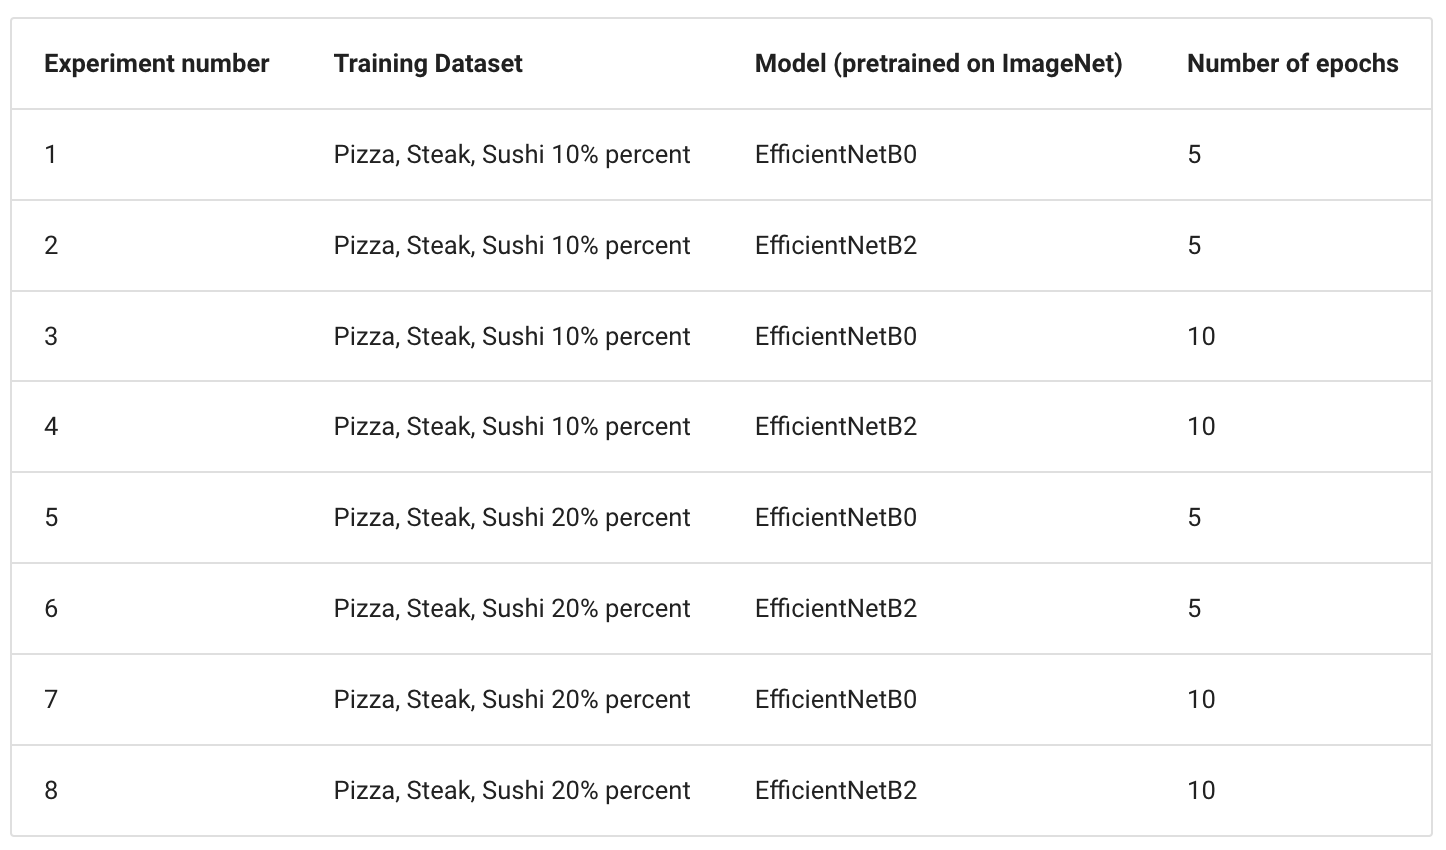

- 실험을 진행해가면서 데이터 사이즈, 모델 사이즈, 학습 길이를 증가시킨다.  
- 마지막에 와서는 모두 두배가 된다.

#### Download different datasets

실험 전에 데이터셋을 준비해야 한다.  
두가지 형태의 데이터셋이 필요하다.  
- A training set with 10% of the data of Food101 pizza, steak, sushi images (앞에서 사용한 것)  
- A training set with 20% of the data of Food101 pizza, steak, sushi images.  

테스트 데이터는 동일한 것을 사용한다.

In [27]:
data_10_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                                     destination="pizza_steak_sushi")

data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

[INFO] data/pizza_steak_sushi directory exists, skipping download.
[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


In [29]:
print(data_10_percent_path)
print(data_20_percent_path)

data/pizza_steak_sushi
data/pizza_steak_sushi_20_percent


In [30]:
# Setup training directory paths
train_dir_10_percent = data_10_percent_path / "train"
train_dir_20_percent = data_20_percent_path / "train"

# Setup testing directory paths (note: use the same test dataset for both to compare the results)
test_dir = data_10_percent_path / "test"

# Check the directories
print(f"Training directory 10%: {train_dir_10_percent}")
print(f"Training directory 20%: {train_dir_20_percent}")
print(f"Testing directory: {test_dir}")

Training directory 10%: data/pizza_steak_sushi/train
Training directory 20%: data/pizza_steak_sushi_20_percent/train
Testing directory: data/pizza_steak_sushi/test


#### Transform Datasets and create DataLoaders

그냥 앞에했던 매뉴얼 방식 그대로 사용  
- Resize all the images (224, 224 but this could be changed).
- Turn them into tensors with values between 0 & 1.
- Normalize them in way so their distributions are inline with the ImageNet dataset (we do this because our models from torchvision.models have been pretrained on ImageNet).

In [31]:
from torchvision import transforms

# ImageNet과 같은 분포를 가지도록..
normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406], # [r, g, b]
                                std = [0.229, 0.224, 0.225])

simple_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize,
])

배치사이즈 32로 데이터로더 생성

In [32]:
BATCH_SIZE = 32

# Create 10% training and test DataLoaders
train_dataloader_10_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_10_percent,
    test_dir=test_dir, 
    transform=simple_transform,
    batch_size=BATCH_SIZE
)

# Create 20% training and test data DataLoders
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
    test_dir=test_dir,
    transform=simple_transform,
    batch_size=BATCH_SIZE
)

# Find the number of samples/batches per dataloader (using the same test_dataloader for both experiments)
print(f"Number of batches of size {BATCH_SIZE} in 10 percent training data: {len(train_dataloader_10_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in 20 percent training data: {len(train_dataloader_20_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in testing data: {len(train_dataloader_10_percent)} (all experiments will use the same test set)")
print(f"Number of classes: {len(class_names)}, class names: {class_names}")

Number of batches of size 32 in 10 percent training data: 8
Number of batches of size 32 in 20 percent training data: 15
Number of batches of size 32 in testing data: 8 (all experiments will use the same test set)
Number of classes: 3, class names: ['pizza', 'steak', 'sushi']


#### Create feature extractor models

우리는 두개 모델을 생성한다.   
- torchvision.models.efficientnet_b0(): pretrained backbone + custom classifier head (EffNetB0 for short).
- torchvision.models.efficientnet_b2(): pretrained backbone + custom classifier head (EffNetB2 for short).


이를 위해 베이스레이어(피처레이어)부분을 프리징하고, 분류기 부분(output layer)은 수정한다.

중요한 점은 입력, 출력의 shape를 확인해야하는 점이다.   
- 입력은 input_size=(32, 3, 224, 224)이 되어야 한다. (batch_size, color_channels, height, width)   
- 출력은...

예를들어 EffNetB2dml 입력 모양부터 마지막 레이어까지 보기 위해서   
- Create an instance of torchvision.models.efficientnet_b2(pretrained=True).
- See the various input and output shapes by running torchinfo.summary().
- Print out the number of in_features by inspecting state_dict() of the classifier portion of EffNetB2 and printing the length of the weight matrix.


In [34]:
import torchvision
from torchinfo import summary

# 1. pretrained 된 가중치로 EffNetB2 인스턴스생성
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # DEFAULT : best available
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

# 2. Get a summary of standard EffNetB2 from torchvision.models
summary(model = effnetb2,
       input_size=(32, 3, 224, 224),
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

# 3. classifier layer의 in_feature 수 확인
print(f"Number of in_features to final layer of EfficientNetB2: {len(effnetb2.classifier.state_dict()['1.weight'][0])}")

Number of in_features to final layer of EfficientNetB2: 1408


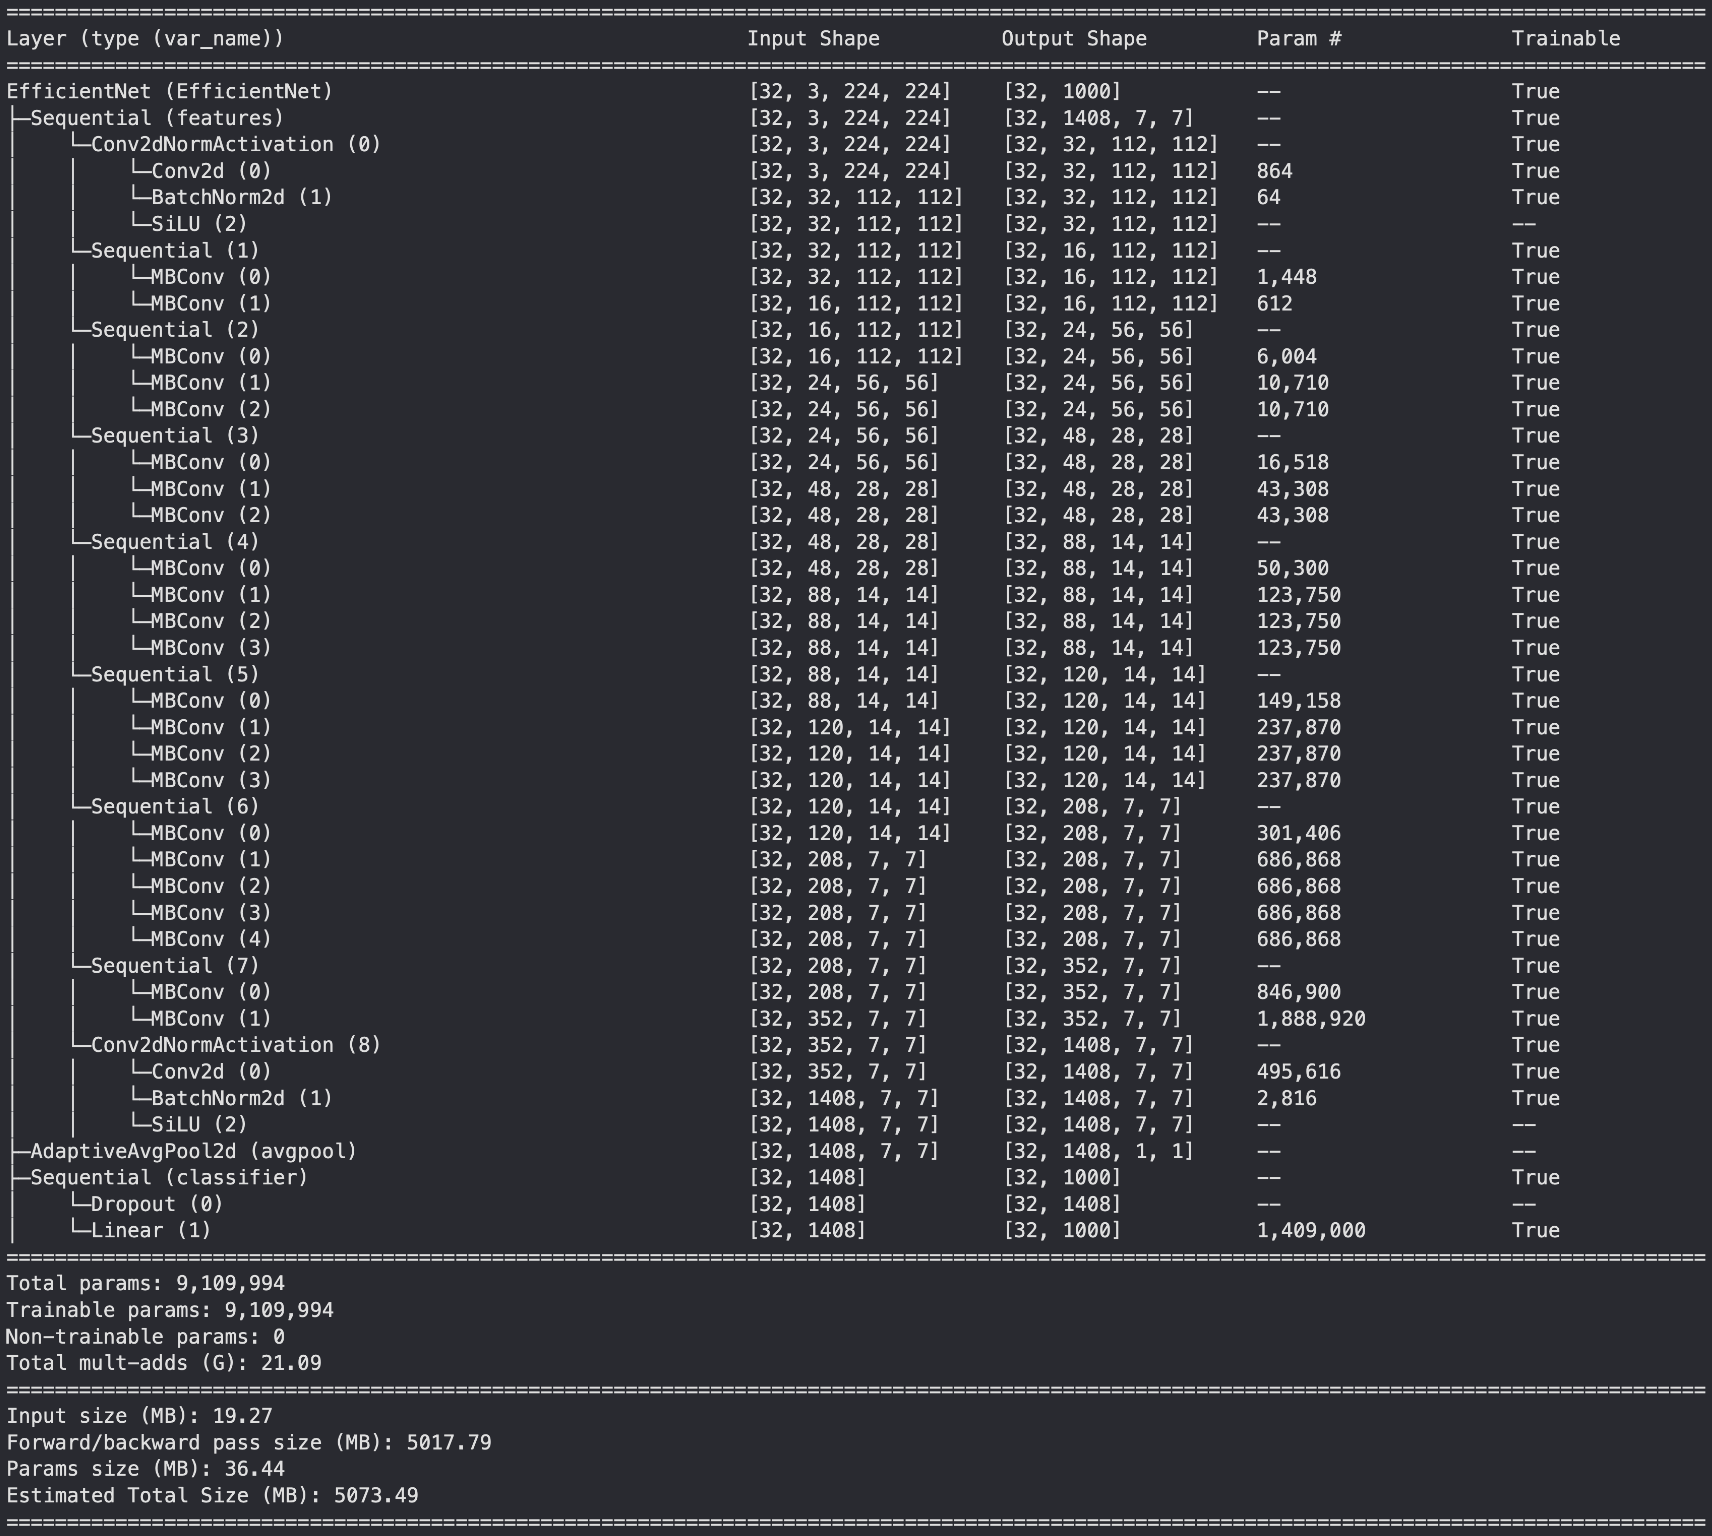

- 현재는 피처추출부분이 프리징 상태가 아니고, 디펄트 분류기 헤드이다.   
- 이제 in_features 수를 알았기 때문에 헬퍼함수를 만들어세 두 모델을 세팅한다.

헬퍼 함수는 다음 기능을 한다.   

- torchvision.models에서 기본 모델을 가져옵니다.
- 모델에서 기본 레이어를 고정합니다(requires_grad=False 설정).
- 무작위 시드를 설정합니다(이 작업을 수행할 필요는 없지만 일련의 실험을 실행하고 무작위 가중치로 새 레이어를 초기화하기 때문에 각 실험마다 무작위성이 비슷하기를 원합니다).
- 분류기 헤드를 변경합니다(문제에 맞게).
- 모델에 이름을 지정합니다(예: EffNetB0의 경우 "effnetb0").

In [35]:
import torchvision
from torch import nn

In [36]:
OUT_FEATURES = len(class_names)
OUT_FEATURES

3

In [37]:
def create_effnetb0():
    # 1. pretrained model과 가중치를 타겟 디바이스로 보낸다.
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)
    
    # 2. 피처추출부분 프리징
    for param in model.features.parameters():
        param.requires_grad = False
        
    # 3. Set the seeds
    set_seeds()
    
    # 4. 분류기 헤드 변경
    model.classifier = nn.Sequential(
        nn.Dropout(p = 0.2),
        nn.Linear(in_features=1280, out_features=OUT_FEATURES)
    ).to(device)
    
    # 5. Give the model a name
    model.name = "effnetb0"
    print(f"[INFO] Created new {model.name} model.")
    return model

In [38]:
# Create an EffNetB2 feature extractor
def create_effnetb2():
    # 1. Get the base model with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    set_seeds()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features=1408, out_features=OUT_FEATURES)
    ).to(device)

    # 5. Give the model a name
    model.name = "effnetb2"
    print(f"[INFO] Created new {model.name} model.")
    return model

In [39]:
effnetb0 = create_effnetb0()

[INFO] Created new effnetb0 model.


In [40]:
summary(model=effnetb0, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [42]:
effnetb2 = create_effnetb2()

#Get an output summary of the layers in our EffNetB2 feature extractor model (uncomment to view full output)
summary(model=effnetb2, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

[INFO] Created new effnetb2 model.


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

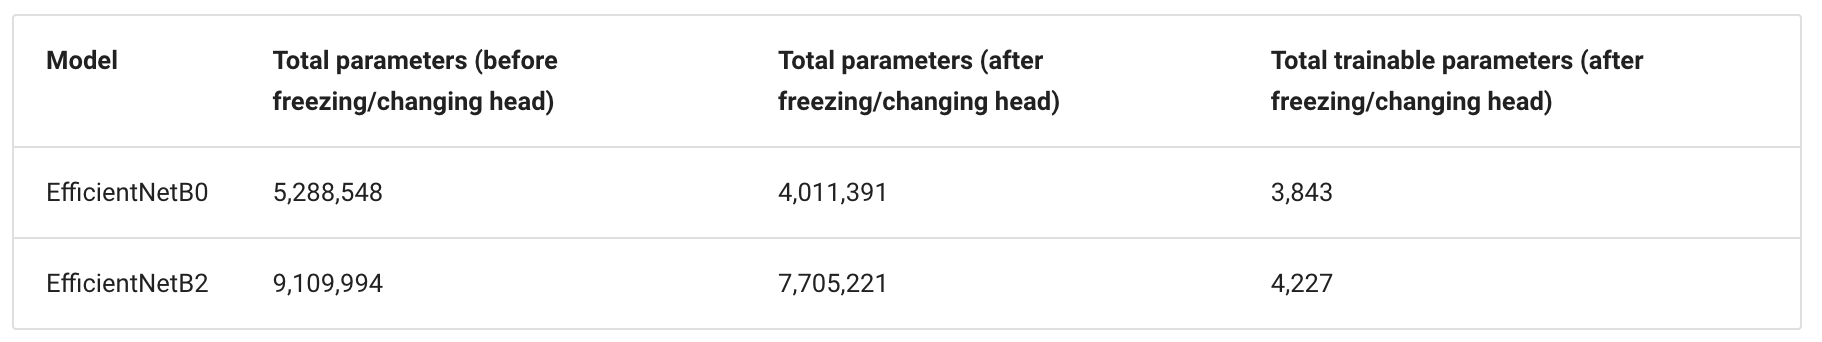

B2의 파라미터 수가 훨씬 많다.  
파라미터가 많으면 성능이 더 좋을까?

#### Create experiments and set up training code

- A list of the number of epochs we'd like to test ([5, 10])
- A list of the models we'd like to test (["effnetb0", "effnetb2"])
- A dictionary of the different training DataLoaders


In [43]:
# 1. 에포크 리스트 
num_epochs = [5, 10]

# 2. 모델 리스트
models = ["effnetb0", "effnetb2"]

# 3. 데이터로더 딕셔너리
train_dataloaders = {"data_10_percent": train_dataloader_10_percent,
                     "data_20_percent": train_dataloader_20_percent}

이제 다음 스텝을 진행한다.  

- 무작위 시드를 설정합니다(실험 결과를 재현할 수 있도록, 실제로는 최대 3개의 다른 시드에 대해 동일한 실험을 실행하고 결과를 평균을 취할수도 있다.).
- 다양한 실험 번호를 추적합니다.
- 각기 다른 훈련 데이터로더에 대해 train_dataloaders 딕셔너리 항목을 반복합니다.
- 에포크 번호 목록을 반복합니다.
- 다양한 모델 이름 목록을 반복합니다.
- 현재 실행 중인 실험에 대한 정보를 출력합니다(무슨 일이 일어나고 있는지 알 수 있도록).
- 어떤 모델이 대상 모델인지 확인하고 새 EffNetB0 또는 EffNetB2 인스턴스를 생성합니다(모든 모델이 동일한 관점에서 시작하도록 각 실험마다 새 모델 인스턴스를 생성).
- 각각의 새로운 실험에 대해 새로운 손실 함수(torch.nn.CrossEntropyLoss())와 최적화기(torch.optim.Adam(params=model.parameters(), lr=0.001))를 생성합니다.
- 수정된 train() 함수를 사용하여 적절한 세부 정보를 writer 파라미터에 전달하여 모델을 훈련합니다.
- 훈련된 모델을 utils.py의 save_model()을 사용하여 적절한 파일 이름으로 파일에 저장합니다.
또한 %%time 매직을 사용하여 모든 실험이 하나의 Jupyter/Google Colab 셀에서 얼마나 오래 걸리는지 확인할 수 있습니다.


In [46]:
%%time
from going_modular.utils import save_model

# 1. 랜덤시드
set_seeds(seed=42)

# 2. 실험번호 추척
experiment_number = 0

# 3. 데이터로더 루프
for dataloader_name, train_dataloader in train_dataloaders.items():
    
    # 4. 에포크 루프
    for epochs in num_epochs:
        # 5. 모델 루프
        for model_name in models:
            # 6. 실험정보 출력
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}") 
            
            # 7. 모델 선택
            if model_name == "effnetb0":
                model = create_effnetb0() # 매번 새모델 생성
            else:
                model = create_effnetb2() # 매번 새모델 생성
                
            # 8. 손실함수, 옵티마이저
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.001)
            
            # 9. 학습, 실험추적
            train(model=model,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader, 
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  epochs=epochs,
                  device=device,
                  writer=create_writer(experiment_name=dataloader_name,
                                       model_name=model_name,
                                       extra=f"{epochs}_epochs"))
            
            # 10. Save the model to file so we can get back the best model
            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model,
                       target_dir="models",
                       model_name=save_filepath)
            print("-"*50 + "\n")
            

[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2023-05-18/data_10_percent/effnetb0/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0499 | train_acc: 0.4492 | test_loss: 0.9289 | test_acc: 0.4470
Epoch: 2 | train_loss: 0.9343 | train_acc: 0.5273 | test_loss: 0.8181 | test_acc: 0.6411
Epoch: 3 | train_loss: 0.7882 | train_acc: 0.7227 | test_loss: 0.6943 | test_acc: 0.8864
Epoch: 4 | train_loss: 0.6933 | train_acc: 0.8828 | test_loss: 0.6510 | test_acc: 0.8968
Epoch: 5 | train_loss: 0.6947 | train_acc: 0.7383 | test_loss: 0.6434 | test_acc: 0.7945
[INFO] Saving model to: models/07_effnetb0_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs/2023-05-18/data_10_percent/effnetb2/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0917 | train_acc: 0.3984 | test_loss: 0.9386 | test_acc: 0.7519
Epoch: 2 | train_loss: 0.9300 | train_acc: 0.6562 | test_loss: 0.8862 | test_acc: 0.7841
Epoch: 3 | train_loss: 0.7961 | train_acc: 0.8398 | test_loss: 0.7379 | test_acc: 0.9384
Epoch: 4 | train_loss: 0.7130 | train_acc: 0.7734 | test_loss: 0.7048 | test_acc: 0.9176
Epoch: 5 | train_loss: 0.6842 | train_acc: 0.7812 | test_loss: 0.7057 | test_acc: 0.8769
[INFO] Saving model to: models/07_effnetb2_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2023-05-18/data_10_percent/effnetb0/10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0499 | train_acc: 0.4492 | test_loss: 0.9289 | test_acc: 0.4470
Epoch: 2 | train_loss: 0.9343 | train_acc: 0.5273 | test_loss: 0.8181 | test_acc: 0.6411
Epoch: 3 | train_loss: 0.7882 | train_acc: 0.7227 | test_loss: 0.6943 | test_acc: 0.8864
Epoch: 4 | train_loss: 0.6933 | train_acc: 0.8828 | test_loss: 0.6510 | test_acc: 0.8968
Epoch: 5 | train_loss: 0.6947 | train_acc: 0.7383 | test_loss: 0.6434 | test_acc: 0.7945
Epoch: 6 | train_loss: 0.5725 | train_acc: 0.9062 | test_loss: 0.5533 | test_acc: 0.8968
Epoch: 7 | train_loss: 0.5499 | train_acc: 0.7930 | test_loss: 0.5333 | test_acc: 0.9176
Epoch: 8 | train_loss: 0.5092 | train_acc: 0.8164 | test_loss: 0.5160 | test_acc: 0.9072
Epoch: 9 | train_loss: 0.5794 | train_acc: 0.7852 | test_loss: 0.5335 | test_acc: 0.8665
Epoch: 10 | train_loss: 0.4576 | train_acc: 0.8242 | test_loss: 0.4582 | test_acc: 0.8968
[INFO] Saving model to: models/07_effnetb0_data_10_percent_10_epochs.pth
------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0917 | train_acc: 0.3984 | test_loss: 0.9386 | test_acc: 0.7519
Epoch: 2 | train_loss: 0.9300 | train_acc: 0.6562 | test_loss: 0.8862 | test_acc: 0.7841
Epoch: 3 | train_loss: 0.7961 | train_acc: 0.8398 | test_loss: 0.7379 | test_acc: 0.9384
Epoch: 4 | train_loss: 0.7130 | train_acc: 0.7734 | test_loss: 0.7048 | test_acc: 0.9176
Epoch: 5 | train_loss: 0.6842 | train_acc: 0.7812 | test_loss: 0.7057 | test_acc: 0.8769
Epoch: 6 | train_loss: 0.6164 | train_acc: 0.8086 | test_loss: 0.6166 | test_acc: 0.8977
Epoch: 7 | train_loss: 0.5576 | train_acc: 0.7969 | test_loss: 0.6231 | test_acc: 0.8769
Epoch: 8 | train_loss: 0.5705 | train_acc: 0.7891 | test_loss: 0.5646 | test_acc: 0.9176
Epoch: 9 | train_loss: 0.4783 | train_acc: 0.9258 | test_loss: 0.5526 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.5241 | train_acc: 0.8164 | test_loss: 0.5837 | test_acc: 0.8466
[INFO] Saving model to: models/07_effnetb2_data_10_percent_10_epochs.pth
------------------------------------

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9693 | train_acc: 0.5542 | test_loss: 0.6603 | test_acc: 0.8655
Epoch: 2 | train_loss: 0.7030 | train_acc: 0.8333 | test_loss: 0.5791 | test_acc: 0.8873
Epoch: 3 | train_loss: 0.5660 | train_acc: 0.8417 | test_loss: 0.4732 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.4905 | train_acc: 0.8792 | test_loss: 0.4289 | test_acc: 0.9072
Epoch: 5 | train_loss: 0.3992 | train_acc: 0.9125 | test_loss: 0.3904 | test_acc: 0.9280
[INFO] Saving model to: models/07_effnetb0_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 6
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs/2023-05-18/data_20_percent/effnetb2/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9804 | train_acc: 0.5396 | test_loss: 0.7977 | test_acc: 0.8049
Epoch: 2 | train_loss: 0.7556 | train_acc: 0.7875 | test_loss: 0.6652 | test_acc: 0.8759
Epoch: 3 | train_loss: 0.6433 | train_acc: 0.7896 | test_loss: 0.5650 | test_acc: 0.9072
Epoch: 4 | train_loss: 0.5265 | train_acc: 0.8729 | test_loss: 0.5552 | test_acc: 0.8977
Epoch: 5 | train_loss: 0.4353 | train_acc: 0.9062 | test_loss: 0.4959 | test_acc: 0.9176
[INFO] Saving model to: models/07_effnetb2_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 7
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2023-05-18/data_20_percent/effnetb0/10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9693 | train_acc: 0.5542 | test_loss: 0.6603 | test_acc: 0.8655
Epoch: 2 | train_loss: 0.7030 | train_acc: 0.8333 | test_loss: 0.5791 | test_acc: 0.8873
Epoch: 3 | train_loss: 0.5660 | train_acc: 0.8417 | test_loss: 0.4732 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.4905 | train_acc: 0.8792 | test_loss: 0.4289 | test_acc: 0.9072
Epoch: 5 | train_loss: 0.3992 | train_acc: 0.9125 | test_loss: 0.3904 | test_acc: 0.9280
Epoch: 6 | train_loss: 0.3844 | train_acc: 0.8979 | test_loss: 0.3494 | test_acc: 0.9176
Epoch: 7 | train_loss: 0.4229 | train_acc: 0.8354 | test_loss: 0.3270 | test_acc: 0.9384
Epoch: 8 | train_loss: 0.3340 | train_acc: 0.9229 | test_loss: 0.3404 | test_acc: 0.9186
Epoch: 9 | train_loss: 0.3167 | train_acc: 0.9271 | test_loss: 0.2938 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.3189 | train_acc: 0.8854 | test_loss: 0.3028 | test_acc: 0.8977
[INFO] Saving model to: models/07_effnetb0_data_20_percent_10_epochs.pth
------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9804 | train_acc: 0.5396 | test_loss: 0.7977 | test_acc: 0.8049
Epoch: 2 | train_loss: 0.7556 | train_acc: 0.7875 | test_loss: 0.6652 | test_acc: 0.8759
Epoch: 3 | train_loss: 0.6433 | train_acc: 0.7896 | test_loss: 0.5650 | test_acc: 0.9072
Epoch: 4 | train_loss: 0.5265 | train_acc: 0.8729 | test_loss: 0.5552 | test_acc: 0.8977
Epoch: 5 | train_loss: 0.4353 | train_acc: 0.9062 | test_loss: 0.4959 | test_acc: 0.9176
Epoch: 6 | train_loss: 0.4612 | train_acc: 0.8417 | test_loss: 0.4629 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.3964 | train_acc: 0.8646 | test_loss: 0.4787 | test_acc: 0.8570
Epoch: 8 | train_loss: 0.3438 | train_acc: 0.9208 | test_loss: 0.4027 | test_acc: 0.9384
Epoch: 9 | train_loss: 0.3425 | train_acc: 0.9125 | test_loss: 0.4129 | test_acc: 0.9280
Epoch: 10 | train_loss: 0.3291 | train_acc: 0.8875 | test_loss: 0.4168 | test_acc: 0.8873
[INFO] Saving model to: models/07_effnetb2_data_20_percent_10_epochs.pth
------------------------------------

### 9. Load in the best model and make predictions with it

8번 실험이 전반적으로 가장 좋은 결과를 얻은 것으로 보인다.   
이 실험의 개요는 다음과 같다.  
- EffNetB2(EffNetB0의 두 배 매개변수)
- 20% 피자, 스테이크, 스시 훈련 데이터(원래 훈련 데이터의 두 배)
- 10회의 에포크(원래 훈련 시간의 2배)

가장 큰 모델이 가장 좋은 결과를 얻었습니다.

그런데 훨씬 좋은 것은 아니었다.  
6번의 경우 훈련시간이 절반이었지만 결과는 비슷했다.   

결과를 자세히 살펴보면 일반적으로 더 많은 매개변수(EffNetB2)와 더 많은 데이터(피자, 스테이크, 스시 훈련 데이터 20%)를 가진 모델이 더 나은 성능(테스트 손실 감소 및 테스트 정확도 증가)을 보이는 것으로 나타났습니다.

이를 더 테스트하기 위해 더 많은 실험을 수행할 수 있지만, 지금은 실험 8에서 가장 성능이 좋은 모델을 가져와(저장 위치: models/07_effnetb2_data_20_percent_10_epochs.pth, 이 모델은 GitHub에서 다운로드 가능) 몇 가지 정성적 평가를 수행해 보겠습니다.

In [48]:
best_model_path = 'models/07_effnetb2_data_20_percent_10_epochs.pth'

best_model = create_effnetb2()

best_model.load_state_dict(torch.load(best_model_path))

[INFO] Created new effnetb2 model.


<All keys matched successfully>

In [49]:
best_model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

모델의 파일 사이즈도 체크해보자.  
배포를 고려한다면 모델 사이즈도 중요한 고려사항이다.

In [50]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
effnetb2_model_size = Path(best_model_path).stat().st_size // (1024*1024)
print(f"EfficientNetB2 feature extractor model size: {effnetb2_model_size} MB")

EfficientNetB2 feature extractor model size: 29 MB


이제 pred_and_plot_image() 함수를 사용해서 테스트를 해보자.

In [51]:
from going_modular.predictions import pred_and_plot_image
import random

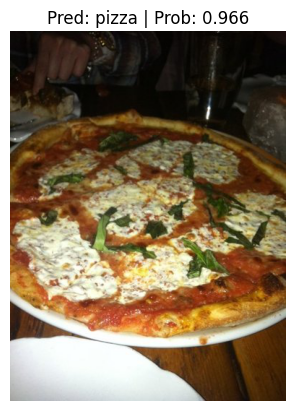

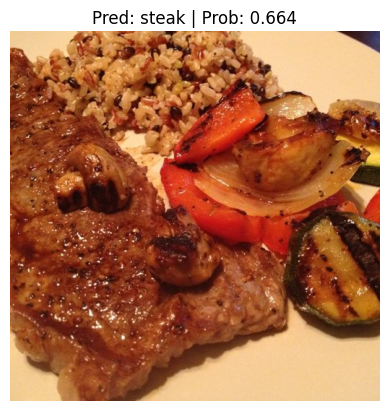

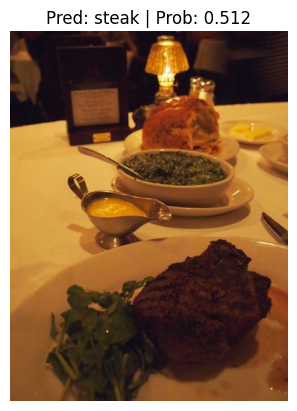

In [53]:
num_images_to_plot = 3
test_image_path_list = list(Path(data_20_percent_path / "test").glob("*/*.jpg")) # get all test image paths from 20% dataset
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot) # randomly select k number of images

# Iterate through random test image paths, make predictions on them and plot them
for image_path in test_image_path_sample:
    pred_and_plot_image(model=best_model,
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224, 224))

Predict on a custom image with the best model

data/04-pizza-dad.jpeg already exists, skipping download.


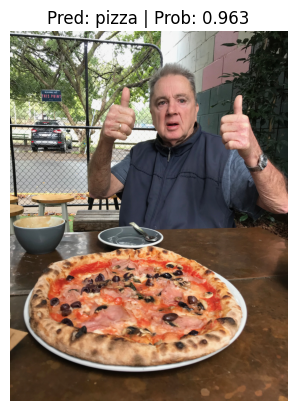

In [54]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = Path("data/04-pizza-dad.jpeg")

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)